In [ ]:
we’ll apply OpenCV’s EAST text detector to detect the presence of text in an image. The EAST text detector will give us the bounding box (x, y)-coordinates of text ROIs.

We’ll extract each of these ROIs and then pass them into Tesseract v4’s LSTM deep learning text recognition algorithm.

The output of the LSTM will give us our actual OCR results.

Finally, we’ll draw the OpenCV OCR results on our output image.



In [ ]:
When calling the tessarct  command under pytessaract library we need to supply a number of flags. The three most important ones are -l , --oem , and --psm .

The -l  flag controls the language of the input text. We’ll be using eng  (English) for this example but you can see all the languages Tesseract supports here.

The --oem  argument, or OCR Engine Mode, controls the type of algorithm used by Tesseract.



#OCR Engine Modes 
$ tesseract --help-oem
OCR Engine modes:
  0    Legacy engine only.
  1    Neural nets LSTM engine only.
  2    Legacy + LSTM engines.
  3    Default, based on what is available.
##We will use --oem 1  to indicate the deep learning LSTM engine.

#Page segmentation modes
$ tesseract --help-psm
Page segmentation modes:
  0    Orientation and script detection (OSD) only.
  1    Automatic page segmentation with OSD.
  2    Automatic page segmentation, but no OSD, or OCR. (not implemented)
  3    Fully automatic page segmentation, but no OSD. (Default)
  4    Assume a single column of text of variable sizes.
  5    Assume a single uniform block of vertically aligned text.
  6    Assume a single uniform block of text.
  7    Treat the image as a single text line.
  8    Treat the image as a single word.
  9    Treat the image as a single word in a circle.
 10    Treat the image as a single character.
 11    Sparse text. Find as much text as possible in no particular order.
 12    Sparse text with OSD.
 13    Raw line. Treat the image as a single text line,
       bypassing hacks that are Tesseract-specific.
       
##For OCR’ing text ROIs we can use modes 6  and 7, but if you’re OCR’ing large blocks of text then you may want to try 3 , the default mode.    

## We can try to adjust the --psm value if we are getting incorrect OCR results.
       

In [1]:

import numpy as np
import pytesseract
import argparse
import cv2
import matplotlib.pyplot as plt

width=320
height=320
image_path1 = 'images/example_01.jpg'
image_path2 = 'images/example_02.jpg'
image_path3 = 'images/computer-vision.jpg'
text_detector_path= 'frozen_east_text_detection.pb'
min_confidence = 0.5
padding=0.0


In [2]:
#--Uses a deep learning-based Opencv EAST text detector to detect (not recognize) regions of text in an image.
#--The text detector produces two arrays, one containing the probability of a given area containing text, 
#--and another that maps the score to a bounding box location in the input image.

def decode_predictions(scores, geometry):
    # grab the number of rows and columns from the scores volume, then
    # initialize our set of bounding box rectangles and corresponding
    # confidence scores
    (numRows, numCols) = scores.shape[2:4]
    rects = []
    confidences = []

    # loop over the number of rows
    for y in range(0, numRows):
        # extract the scores (probabilities), followed by the
        # geometrical data used to derive potential bounding box
        # coordinates that surround text
        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]

        # loop over the number of columns
        for x in range(0, numCols):
            # if our score does not have sufficient probability,
            # ignore it
            if scoresData[x] < min_confidence:
                continue

            # compute the offset factor as our resulting feature
            # maps will be 4x smaller than the input image
            (offsetX, offsetY) = (x * 4.0, y * 4.0)

            # extract the rotation angle for the prediction and
            # then compute the sin and cosine
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)

            # use the geometry volume to derive the width and height
            # of the bounding box
            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]

            # compute both the starting and ending (x, y)-coordinates
            # for the text prediction bounding box
            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)

            # add the bounding box coordinates and probability score
            # to our respective lists
            rects.append([startX, startY, int(endX), int(endY)])
            confidences.append(float(scoresData[x]))

    # return a tuple of the bounding boxes and associated confidences
    return (rects, confidences)

In [3]:
# construct the argument parser and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-i", "--image", type=str,help="path to input image")
# ap.add_argument("-east", "--east", type=str,help="path to input EAST text detector")
# ap.add_argument("-c", "--min-confidence", type=float, default=0.5,help="minimum probability required to inspect a region")
# ap.add_argument("-w", "--width", type=int, default=320,help="nearest multiple of 32 for resized width")
# ap.add_argument("-e", "--height", type=int, default=320,help="nearest multiple of 32 for resized height")
# ap.add_argument("-p", "--padding", type=float, default=0.0,help="amount of padding to add to each border of ROI")
# args = ap.parse_args()

In [4]:
def resize_image(image):
    #grab the image dimensions
    (origH, origW) = image.shape[:2]

    # set the new width and height and then determine the ratio in change
    # for both the width and height

    (newW, newH) = (width, height)
    rW = origW / float(newW)
    rH = origH / float(newH)

    # resize the image and grab the new image dimensions
    image = cv2.resize(image, (newW, newH))
    return rW,rH,image

In [5]:
# define the two output layer names for the EAST detector model that
# we are interested in -- the first is the output probabilities and the
# second can be used to derive the bounding box coordinates of text
def load_text_detector(text_detector_path):
    layerNames = [
        "feature_fusion/Conv_7/Sigmoid",
        "feature_fusion/concat_3"]

    # load the pre-trained EAST text detector
    print("[INFO] loading EAST text detector...")
    net = cv2.dnn.readNet(text_detector_path)
    return net,layerNames


In [6]:
# construct a blob from the image and then perform a forward pass of
# the model to obtain the two output layer sets
def net_forward(image,net,layerNames):
    (H, W) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),
        (123.68, 116.78, 103.94), swapRB=True, crop=False)
    net.setInput(blob)
    (scores, geometry) = net.forward(layerNames)

    # decode the predictions, then  apply non-maxima suppression to
    # suppress weak, overlapping bounding boxes
    (boxes, confidences) = decode_predictions(scores, geometry)
    nms_threshold =0.3
    box_ids = cv2.dnn.NMSBoxes(boxes,confidences,min_confidence,nms_threshold)
    return box_ids,boxes


In [7]:

def extract_text_roi(box_ids,boxes,image,orig,rH,rW):

    (origH, origW) = orig.shape[:2]
  
    # loop over the bounding boxes
    if len(box_ids) > 0:
        # loop over the indexes we are keeping
        for i in box_ids.flatten():
            # extract the bounding box coordinates
            (startX, startY) = (boxes[i][0], boxes[i][1])
            (endX, endY) = (boxes[i][2], boxes[i][3])

            # scale the bounding box coordinates based on the respective
            # ratios
            startX = int(startX * rW)
            startY = int(startY * rH)
            endX = int(endX * rW)
            endY = int(endY * rH)

            # in order to obtain a better OCR of the text we can potentially
            # apply a bit of padding surrounding the bounding box -- here we
            # are computing the deltas in both the x and y directions
            dX = int((endX - startX) * padding)
            dY = int((endY - startY) * padding)

            # apply padding to each side of the bounding box, respectively
            startX = max(0, startX - dX)
            startY = max(0, startY - dY)
            endX = min(origW, endX + (dX * 2))
            endY = min(origH, endY + (dY * 2))

            # extract the actual padded ROI
            roi = orig[startY:endY, startX:endX]
            return roi,startX,startY,endX,endY

In [8]:
def convert_img_text(roi,startX,startY,endX,endY):
    # in order to apply Tesseract v4 to OCR text we must supply
    # (1) a language, (2) an OEM flag of 4, indicating that the we
    # wish to use the LSTM neural net model for OCR, and finally
    # (3) an OEM value, in this case, 7 which implies that we are
    # treating the ROI as a single line of text
    
    # initialize the list of results
    results = []
    config = ("-l eng --oem 1 --psm 7")
    text = pytesseract.image_to_string(roi, config=config)

    # add the bounding box coordinates and OCR'd text to the list
    # of results
    results.append(((startX, startY, endX, endY), text))
    return results

In [9]:
def show_result(results,orig):
    # sort the results bounding box coordinates from top to bottom
    results = sorted(results, key=lambda r:r[0][1])

    # loop over the results
    for ((startX, startY, endX, endY), text) in results:
        # display the text OCR'd by Tesseract
        print("OCR TEXT")
        print("========")
        print("{}\n".format(text))

        # strip out non-ASCII text so we can draw the text on the image
        # using OpenCV, then draw the text and a bounding box surrounding
        # the text region of the input image
        text = "".join([c if ord(c) < 128 else "" for c in text]).strip()
        output = orig.copy()
        cv2.rectangle(output, (startX, startY), (endX, endY),
            (0, 0, 255), 2)
        cv2.putText(output, text, (startX, startY - 20),
            cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0,255, 0), 3)

        # show the input and output image
        plt.imshow(output)
#         cv2.imshow("Text Detection", output)
#         cv2.waitKey(0)


In [10]:

def ocr_pipeline(img_path):
    # load the input image
    image = cv2.imread(img_path)
    #grab the image dimensions
    orig = image.copy()
    rW,rH,image = resize_image(image)
    net,layerNames = load_text_detector(text_detector_path)
    nms_boxids,boxes = net_forward(image,net,layerNames)
    text_roi,startX,startY,endX,endY = extract_text_roi(nms_boxids,boxes,image,orig,rH,rW)
    results = convert_img_text(text_roi,startX,startY,endX,endY)
    show_result(results,orig)
    

[INFO] loading EAST text detector...
OCR TEXT
OH OK

OH OK


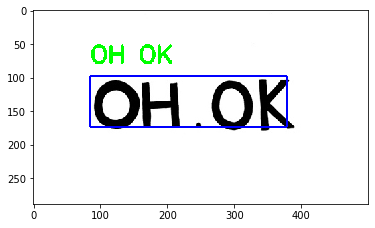

In [11]:
ocr_pipeline(image_path1)


[INFO] loading EAST text detector...
OCR TEXT
® MIDDLEBOROUGH

MIDDLEBOROUGH


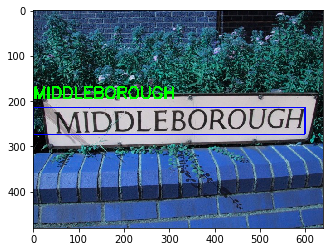

In [12]:
ocr_pipeline(image_path2)

1.1 What is computer vision?

As humans, We perceive the three-dimensional structure of the world around us with apparent
ease. Think of how vivid the three-dimensional percept is when you look at a vase of flowers
sitting on the table next to you. You can tell the shape and translucency of each petal through
the subtle patterns of light and Shading that play across its surface and effortlessly segment
each flower from the background of the scene (Figure 1.1). Looking at a framed group por-
trait, you can easily count (and name) all of the people in the picture and even guess at their
emotions from their facial appearance. Perceptual psychologists have spent decades trying to
understand how the visual system works and, even though they can devise optical illusions!
to tease apart some of its principles (Figure 1.3), a complete solution to this puzzle remains
elusive (Marr 1982; Palmer 1999; Livingstone 2008).


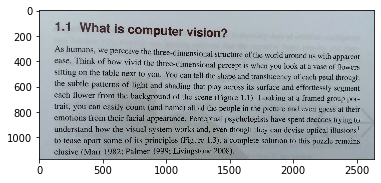

In [24]:
config = ('-l eng --oem 1 --psm 3')

image = cv2.imread(image_path3)
plt.imshow(image)
# Run tesseract OCR on image
text = pytesseract.image_to_string(image, config=config)

# Print recognized text
print(text)